# Nonlinear Pricing

Based on code by Luo, Perrigne, and Vuong (2018, Journal of Political Economy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Set Parameters

In [2]:
from scipy.optimize import fsolve

# Specify parameters
m = {
    'beta': 0.5,
    'K': 5,  # fixed cost
    'r': 0.05,  # marginal cost
    'b': 2,  # [CHOOSE TYPE DISTRIBUTION FUNCTION]
    'w': 1
}

xx = np.arange(m['w'], m['w'] + 1, 0.0001)
xx = xx[:-1]
Ncut = 1000
alpha = np.arange(1/Ncut, 1 + 1/Ncut, 1/Ncut)

# Some useful numbers defined by parameters
m['k0H'] = -(1 + m['w']) / m['b']
m['k1H'] = 1 + 1 / m['b']
m['k0q'] = (m['beta'] / m['r']) * m['k0H']
m['k1q'] = (m['beta'] / m['r']) * m['k1H']

# Functions generated by our distribution
Ffun = lambda x, m: 1 - ((1 - (x - m['w'])) ** m['b'])  # original distribution
ffun = lambda x, m: m['b'] * ((1 - (x - m['w'])) ** (m['b'] - 1))  # original density
Hfun = lambda x, m: m['k0H'] + m['k1H'] * x  # theta - (1-F)/f
Ufun = lambda x, m: x ** m['beta']  # u0 = q^beta

# Eqm mappings
q_theta = lambda x, m: (m['k0q'] + m['k1q'] * x) ** (1 / (1 - m['beta']))  # q(theta)
theta_q = lambda q, m: (-m['k0q'] + q ** (1 - m['beta'])) / m['k1q']  # theta(q)
thetaP_q = lambda q, m: (1 - m['beta']) * (q ** (-m['beta'])) / m['k1q']

Mfun = lambda x, m: Hfun(x, m) * (q_theta(x, m) ** m['beta']) - (m['K'] + m['r'] * q_theta(x, m))  # M(theta)

# Check the M function that defines the cutoff type
# plt.plot(xx, Mfun(xx, m))

# Find the cutoff type
if Mfun(m['w'], m) >= 0:
    m['theta0'] = m['w']  # it's optimal to serve everyone
else:
    m['theta0'] = fsolve(lambda u: Mfun(u, m), m['w'] + 0.5)

# Payment schedule in direct mechanism
t_theta = lambda x, m: x * (q_theta(x, m) ** m['beta']) - \
    ((1 - m['beta']) / m['k1q']) * (
            (m['k0q'] + m['k1q'] * x) ** (1 / (1 - m['beta'])) -
            (m['k0q'] + m['k1q'] * m['theta0']) ** (1 / (1 - m['beta']))
    )

# Tariff function in indirect mechanism
Tfun = lambda q, m: theta_q(q, m) * (q ** m['beta']) - \
    ((1 - m['beta']) / m['k1q']) * (
            (m['k0q'] + m['k1q'] * theta_q(q, m)) ** (1 / (1 - m['beta'])) -
            (m['k0q'] + m['k1q'] * m['theta0']) ** (1 / (1 - m['beta']))
    )

# Marginal tariff function
TPfun = lambda q, m: theta_q(q, m) * m['beta'] * (q ** (m['beta'] - 1)) + \
    (q ** m['beta'] - ((m['k0q'] + m['k1q'] * theta_q(q, m)) ** (1 / (1 - m['beta']) - 1))) * thetaP_q(q, m)

# Truncated distribution function
Fstar = lambda x, m: (Ffun(x, m) - Ffun(m['theta0'], m)) / (1 - Ffun(m['theta0'], m))

# Truncated density function
fstar = lambda x, m: ffun(x, m) / (1 - Ffun(m['theta0'], m))

# TRUE type quantile function (conditioning on purchasing)
theta_alpha = lambda a, m: 1 + m['w'] - \
    (1 - ((1 - Ffun(m['theta0'], m)) * alpha + Ffun(m['theta0'], m))) ** (1 / m['b'])


## Define Auxiliary Functions

In [3]:
def alpha_fun1(theta, m):
    """
    Calculate the corresponding quantile alpha for theta
    """
    
    a_hat = np.arange(1/m['Nobs'], 1 + 1/m['Nobs'], 1/m['Nobs'])
    theta_hat = m['theta0'] * theta_fun1(a_hat, m)
    
    J0 = np.sum(np.tile(theta, (m['Nobs'], 1)) >= np.tile(theta_hat[:, np.newaxis], (1, len(theta))), axis=0)
    J = J0 + 1
    
    J0 = np.arange(1, m['Nobs'])
    
    # Integration of each bin: J = 1,..., N-1 
    intJ = (1 - m['r_hat'] / m['Tp_obs'][J0]) * (-np.log(1 - J0 / m['Nobs']) + np.log(1 - (J0 - 1) / m['Nobs']))
    
    k0 = m['Tp_obs'][-1] - m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])
    k1 = m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])
    
    theta = theta / m['theta0']
    alpha0 = theta.copy()
    
    for i in range(len(theta)):
        if J[i] == 0:
            alpha0[i] = 0
        elif J[i] == 1:
            alpha0[i] = 1 - np.exp(np.log(theta[i]) / (-(1 - m['r_hat'] / m['Tp_obs'][0])))
        elif 2 <= J[i] <= m['Nobs'] - 1:
            alpha0[i] = 1 - np.exp(np.log(1 - (J[i] - 1) / m['Nobs']) - (np.log(theta[i]) - np.sum(intJ[:J[i] - 1])) / (1 - m['r_hat'] / m['Tp_obs'][J[i]]))
        else:  # J[i] = N
            alpha0[i] = (m['Tp_obs'][-2] / np.exp(np.log(theta[i]) - np.sum(intJ)) - k0) / k1
            
    return alpha0


In [4]:
def theta_fun1(alpha, m):
    """
    Normalize theta_cut = 1, estimate type quantile function
    This estimates T'(q(alpha)) using our new estimator
    """
    
    J = np.ceil(m['Nobs'] * alpha)
    J0 = np.arange(1, m['Nobs'])
    
    # Integration of each bin: J = 1,..., N-1
    intJ = (1 - m['r_hat'] / m['Tp_obs'][J0]) * (-np.log(1 - J0 / m['Nobs']) + np.log(1 - (J0 - 1) / m['Nobs']))
    
    k0 = m['Tp_obs'][-1] - m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])
    k1 = m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])
    
    theta = alpha.copy()
    
    for i in range(len(alpha)):
        if J[i] == 0:
            theta[i] = 1
        elif J[i] == 1:
            theta[i] = np.exp(-(1 - m['r_hat'] / m['Tp_obs'][0]) * np.log(1 - alpha[i]))
        elif 2 <= J[i] <= m['Nobs'] - 1:
            temp1 = (1 - m['r_hat'] / m['Tp_obs'][int(J[i])]) * (-np.log(1 - alpha[i]) + np.log(1 - (J[i] - 1) / m['Nobs']))
            theta[i] = np.exp(np.sum(intJ[:int(J[i]) - 1]) + temp1)
        else:  # J[i] = N
            temp2 = np.log(m['Tp_obs'][-2] / (k0 + k1 * alpha[i]))
            theta[i] = np.exp(np.sum(intJ) + temp2)
    
    return theta


In [5]:
def make_fig():
    # Set default text interpreter to LaTeX
    plt.rc('text', usetex=True)
    
    # Plot REPORT A
    plt.subplot(1, 2, 1)
    a1 = np.quantile(results_f1, 0.05, axis=0)
    a2 = np.mean(results_f1, axis=0)
    a3 = np.quantile(results_f1, 0.95, axis=0)

    for i in range(len(theta_truth)):
        f1_temp = results_f1[:, i]
        f1_temp = f1_temp[theta_truth[i] <= theta_max.reshape(-1)]
        if len(f1_temp) > 0:
            a1[i] = np.quantile(f1_temp, 0.05)  # 5% quantile
            a2[i] = np.mean(f1_temp)  # mean
            a3[i] = np.quantile(f1_temp, 0.95)  # 95% quantile
        else:
            a1[i] = f_truth[i]
            a2[i] = a1[i]
            a3[i] = a1[i]

    plt.plot(theta_truth, f_truth, '-.r', theta_truth, a1, ':k', theta_truth, a2, '--b', theta_truth, a3, ':k', linewidth=1.25)
    plt.axis([0.95 * np.min(theta_truth), 2, 0.75 * np.min(f_truth), 1.25 * np.max(f_truth)])
    plt.title(r'$\widehat{f}(\cdot)$')
    plt.xlabel(r'$\theta$')

    # Plot REPORT B
    plt.subplot(1, 2, 2)
    a1 = np.quantile(results_up1, 0.05, axis=0)
    a2 = np.mean(results_up1, axis=0)
    a3 = np.quantile(results_up1, 0.95, axis=0)

    plt.plot(q_truth, Up_truth, '-.r', q_truth, a1, ':k', q_truth, a2, '--b', q_truth, a3, ':k', linewidth=1.25)
    plt.axis([0.95 * np.min(q_truth), 1.05 * np.max(q_truth), 0.95 * np.min(Up_truth), 1.05 * np.max(Up_truth)])
    plt.title(r'$\widehat{U_{0Q}}(\cdot)$')
    plt.xlabel(r'$Q$')

    # Save figure
    plt.savefig(f'b{m["b"]}Nobs{m["Nobs"]}.jpg')
    plt.show()


## Run Monte Carlo Simulation

Running Monte Carlo simulation

Number of observations:  250


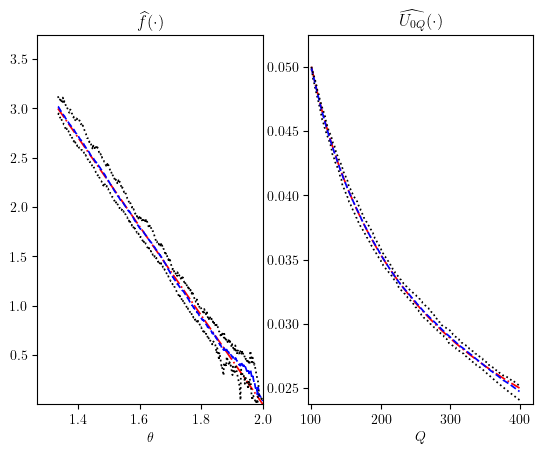

Time elapsed for size 250: 6.31 seconds

Number of observations:  1000


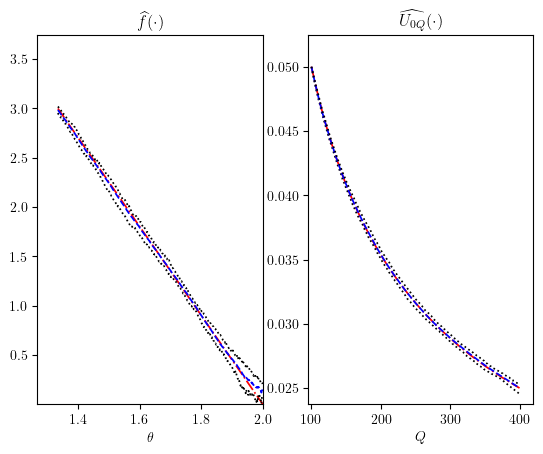

Time elapsed for size 1000: 3.48 seconds

Number of observations:  4000


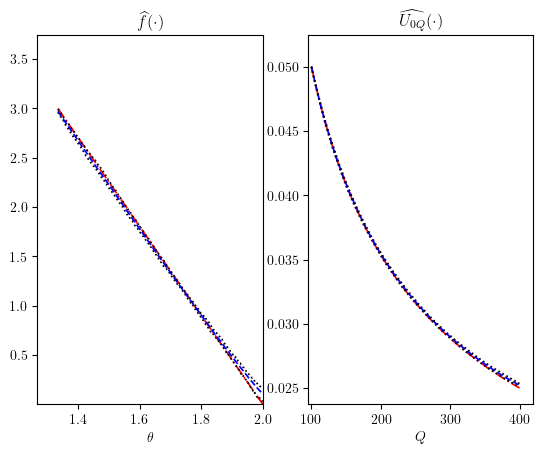

Time elapsed for size 4000: 7.03 seconds


In [6]:
import time

# Clear console
from IPython.display import clear_output

# Set random seed
np.random.seed(888)

# Number of replications
nREP = 20  # Change to 1000 if needed

# Load model predicted functions and parameters from NLPmodel.py
#from NLPmodel import *

print('Running Monte Carlo simulation')

# Perform Monte Carlo simulation
for iSIZE in range(1, 4):
    m['Nobs'] = 250 * (4 ** (iSIZE - 1))
    start_time = time.time()
    print('\nNumber of observations: ', m['Nobs'])

    results_f1 = np.zeros((nREP, len(np.arange(m['theta0'], 2, 1 / Ncut))))
    results_theta1 = np.zeros((nREP, len(np.arange(m['theta0'], 2, 1 / Ncut))))
    results_up1 = np.zeros((nREP, len(np.arange(m['theta0'], 2, 1 / Ncut))))
    results_r = np.zeros((nREP, 1))
    results_K = np.zeros((nREP, 1))
    theta_max = np.zeros((nREP, 1))

    for iREP in range(1, nREP + 1):
        if iREP % 100 == 0:
            clear_output(wait=True)
            print(iREP)

        # DGP: Generate Data
        u = np.random.rand(m['Nobs'] * 100, 1)
        theta = 1 - ((1 - u) ** (1 / m['b'])) + m['w']
        theta = theta[theta >= m['theta0']][:m['Nobs']]
        theta = np.sort(theta)
        m['q_obs'] = q_theta(theta, m)

        # Equation (10): Estimate marginal cost
        Q_max = np.max(m['q_obs']) + 1.06 * np.std(m['q_obs']) * ((1 / len(m['q_obs'])) ** (1 / 5))
        m['r_hat'] = TPfun(Q_max, m)
        m['q_min'] = np.min(m['q_obs'])
        m['K_hat'] = m['r_hat'] * (Tfun(m['q_min'], m) / TPfun(m['q_min'], m) - m['q_min'])

        results_r[iREP - 1] = m['r_hat']
        results_K[iREP - 1] = m['K_hat']

        # Equation (11): Type quantile function
        m['K1TP'] = m['Nobs'] * (TPfun(m['q_obs'][1:], m) - TPfun(m['q_obs'][:-1], m))
        m['K0TP'] = TPfun(m['q_obs'][1:], m) - (np.arange(2, m['Nobs'] + 1) * (m['K1TP'] / m['Nobs']))
        m['Tp_obs'] = TPfun(m['q_obs'], m)

        theta_truth = np.arange(m['theta0'], 2, 1 / Ncut)
        alpha_truth = alpha_fun1(theta_truth, m)
        q_truth = q_theta(theta_truth, m)
        m['J'] = np.ceil(m['Nobs'] * alpha_truth)

        theta_hat1 = m['theta0'] * theta_fun1(alpha_truth, m)
        theta_max[iREP - 1] = m['theta0'] * theta_fun1(np.array([1.]), m)

        # Equation (13): Type density function, marginal utility
        k0 = m['Tp_obs'][-1] - m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])
        k1 = m['Nobs'] * (m['Tp_obs'][-1] - m['Tp_obs'][-2])

        f_hat1 = np.zeros_like(alpha_truth)
        Up_hat1 = np.zeros_like(alpha_truth)

        for i in range(len(alpha_truth)):
            if m['J'][i] == 0:
                Tp = m['Tp_obs'][0]
            elif 1 <= m['J'][i] <= m['Nobs'] - 1:
                Tp = m['Tp_obs'][int(m['J'][i])]
            else:
                Tp = k0 + k1 * alpha_truth[i]

            f_hat1[i] = (1 / theta_hat1[i]) * (1 - alpha_truth[i]) * (Tp / (Tp - m['r_hat']))

            if alpha_truth[i] == 1 and Dr_true == 0:
                f_hat1[i] = (Tp / theta_hat1[i]) * (-1 / k1)

            Up_hat1[i] = Tp / theta_hat1[i]

        f_truth = fstar(theta_truth, m)
        Up_truth = m['beta'] * (q_truth ** (m['beta'] - 1))

        results_f1[iREP - 1, :] = f_hat1
        results_theta1[iREP - 1, :] = theta_hat1
        results_up1[iREP - 1, :] = Up_hat1

    make_fig()
    print(f'Time elapsed for size {m["Nobs"]}: {time.time() - start_time:.2f} seconds')



## Exercises

### Exercise 1

Run the above Monte Carlo simulation.

Run the above Monte Carlo simulation with true density $f(\theta)=1$ for $\theta\in [1,2]$.

### Exercise 2
What happens if you introduce a tax $\tau Q$ with $\tau=0.01$?

Derive the optimal tariff of the monopolist.

What is welfare with the tax?

### Exercise 3

Return to the original specification of Luo, Perrigne, and Vuong. Find the first-best price schedule.

How much welfare is lost compared to first best?